# Three applications of entropy: notebook

This notebook can do most of the computations and make most of the plots for the chapter "Three Applications of Entropy to Gerrymandering". You should explore by playing with parameters, or even putting your own datasets in!

## Application 1: Measuring Segregation
Let's use the information theory concept of entropy to measure segregation in Chicago.

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### These are the functions which compute Ent(R|T) and Ent(R)

In [2]:
#how much information does someone's location give you about their race?
def Ent_R_T(df, R_columns, population_column):
    entropy = 0
    totalpop = sum([float(x) for x in df[population_column]])
    R_population_by_tract = {}
    nonR_population_by_tract = {}
    for index, row in df.iterrows():
        R_population_by_tract[row.name] = sum(float(row[c]) for c in R_columns)
        nonR_population_by_tract[row.name] = float(row[population_column]) - R_population_by_tract[row.name]
        if R_population_by_tract[row.name] > 0:
            entropy -= 1/totalpop*R_population_by_tract[row.name]*np.log2(
                    R_population_by_tract[row.name]/float(row[population_column])
        
            )
        if nonR_population_by_tract[row.name] > 0:
            entropy -= 1/totalpop*nonR_population_by_tract[row.name]*np.log2(
                    nonR_population_by_tract[row.name]/float(row[population_column])
                )
    return entropy

In [3]:
#how hard is it to guess someone's race without geographic information?
def Ent_R(df, R_columns, population_column):
    entropy = 0
    totalpop = sum([float(x) for x in df[population_column]])
    R_population = sum(df[c].sum() for c in R_columns)
    nonR_population = totalpop - R_population
    entropy -= 1/totalpop*R_population*np.log2(
            R_population/totalpop
    )
    entropy -= 1/totalpop*nonR_population*np.log2(
            nonR_population/totalpop
    )
    return entropy

### Let's load some Chicago data

In [4]:
#load the census tracts for Chicago for three different census cycles
chi1990_city = gpd.read_file("chicago/chi1990_city.shp")
chi2000_city = gpd.read_file("chicago/chi2000_city.shp")
chi2010_city = gpd.read_file("chicago/chi2010_city.shp")
dflist = [chi1990_city, chi2000_city, chi2010_city]
label_list = ["1990", "2000", "2010"]

### And now we compute entropy segregation scores

In [5]:
#we'll do Hispanic 2010 as an example, so we need all the Hispanic columns
#which columns you need changes by census cycle so be careful!
race_columns = [
    'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE'
]
census_cycle_data = chi2010_city
EntRT = Ent_R_T(census_cycle_data, race_columns, "TOTPOP")
EntR = Ent_R(census_cycle_data, race_columns, "TOTPOP")
print("Ent(R|T): {:0.3f}".format(EntRT))
print("Ent(R): {:0.3f}".format(EntR))
print("Seg(R,T) = Ent(R|T)/Ent(R) = {:0.3f}".format(EntRT/EntR))

Ent(R|T): 0.528
Ent(R): 0.865
Seg(R,T) = Ent(R|T)/Ent(R) = 0.610


/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/mapclassify/classifiers.py:276: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/mapclassify/classifiers.py:276: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k


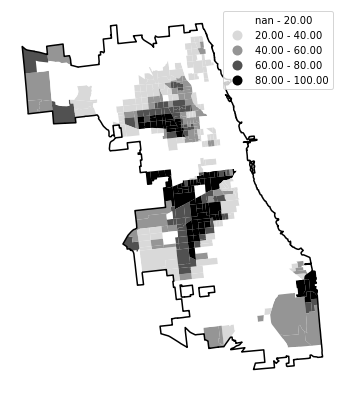

In [6]:
#we can also look at choropleths for this race and census cycle
fig, ax = plt.subplots(figsize=(7,7))
census_cycle_data.plot(
    column=100*census_cycle_data[race_columns].sum(axis=1).divide(census_cycle_data["TOTPOP"]),
    cmap="Greys",
    legend=True,
    scheme='user_defined',
    classification_kwds={'bins':[20, 40, 60, 80, 100]},
    ax=ax
)
census_cycle_data['dummy'] = 1
citytracts = census_cycle_data.dissolve(by='dummy')
citytracts.boundary.plot(
    ax=ax,
    edgecolor='black'
)
plt.axis('off')
plt.show()

Go ahead and change the race_columns and the census_cycle_data above to compute and compare other values!

## Application 2: County splitting
Let's use entropy to find out how much districts are splitting up counties in Pennsylvania.

In [7]:
import geopandas as gpd
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
gdf = gpd.read_file("pennsylvania/PA_VTD_PLANS.shp")

### This function computes Ent(D|C)

In [9]:
#how much information does someone's county give you about their district?
def Ent_D_C(gdf, district_column, county_column, population_column):
    entropy = 0
    totalpop = gdf[population_column].sum()
    district_county_intersections = gdf.groupby(by=[district_column,county_column]).sum()
    county_populations = gdf.groupby(by=county_column).sum()[population_column]
    for i, row in district_county_intersections.iterrows():
        if row[population_column] > 0:
            entropy += 1/totalpop*row[population_column]*np.log2(
                county_populations[row.name[1]]/row[population_column]
            )
    return entropy

### Let's compute Ent(D|C) for a couple of districting plans in Pennsylvania
P.S. if these numbers differ a little bit from the book, it's because we have improved the data since then!

In [10]:
hand_drawn_plans = ['REMEDIAL', 'GOV', 'TS', 'CD_2011',
       '538DEM', '538GOP', '538CMPCT']
entropy_by_plan = pd.DataFrame()
entropy_by_plan["plan"] = hand_drawn_plans
entropy_by_plan["Ent(D|C)"] = [Ent_D_C(gdf,plan,"COUNTYFP10","TOTPOP") for plan in hand_drawn_plans]
print(entropy_by_plan)

       plan  Ent(D|C)
0  REMEDIAL  0.472791
1       GOV  0.576257
2        TS  0.600066
3   CD_2011  0.866629
4    538DEM  0.917197
5    538GOP  0.815087
6  538CMPCT  0.483211


In [11]:
#get the county boundaries
gdf = gdf.to_crs({"init": "epsg:2271"})
county_data_frame = gdf.dissolve(by="COUNTYFP10")

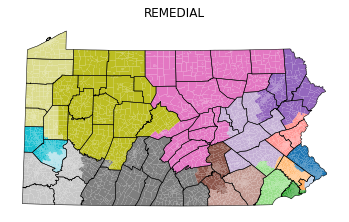

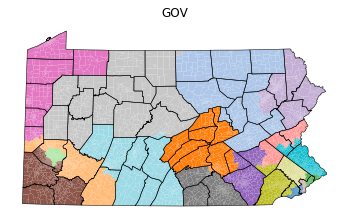

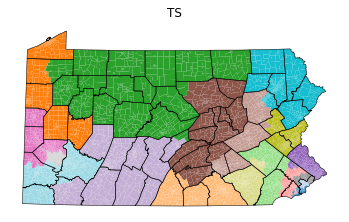

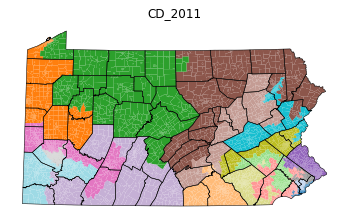

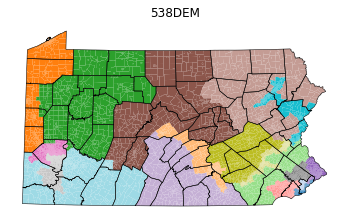

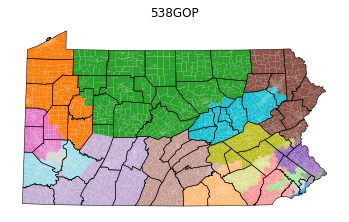

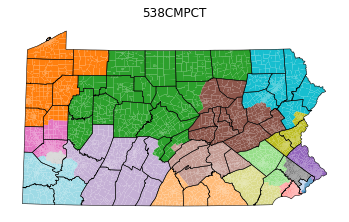

In [13]:
#we can also look at these plans with county boundaries
for index, plan in enumerate(hand_drawn_plans):
    fig, ax = plt.subplots()
    county_data_frame.boundary.plot(color=None, edgecolor="black", linewidth=0.5, ax=ax)
    gdf.plot(column=plan, cmap='tab20', ax=ax)
    plt.axis('off')
    plt.title(plan)
    plt.show()

## Application 3: distance between plans
We can use entropy to quantify how much two different districting plans "differ"

### We can reuse our function from the county splitting application 

In [16]:
#we already have a entropy function for districts and counties...
#.. so we can just reuse that for two districting plans!
def Ent_D_D(gdf, district_column_1, district_column_2, population_column):
    return Ent_D_C(gdf, district_column_1, district_column_2, population_column)

### Let's calculate pairwise distances between the Pennsylvania plans and the 2011 plan

In [17]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
gdf = gpd.read_file("pennsylvania/PA_VTD_PLANS.shp")

In [ ]:
hand_drawn_plans = ['REMEDIAL', 'GOV', 'TS', 'CD_2011',
       '538DEM', '538GOP', '538CMPCT']
distances_between_plans = pd.DataFrame()
distances_between_plans["from"] = ["CD_2011"]
for plan in hand_drawn_plans:
    distances_between_plans[plan] = [Ent_D_D(gdf, "CD_2011", plan, "TOTPOP")]
print(distances_between_plans.set_index("from"))

         REMEDIAL       GOV        TS  CD_2011    538DEM  538GOP  538CMPCT
from                                                                      
CD_2011  1.320555  1.342105  1.144805      0.0  1.670591  1.3159  1.245953


### Let's calculate the distances between consecutive enacted plans in Maryland
We'll just do the redistricting for the 1990 census as an example.  

In [ ]:
#this is a preprocessed block file with assignments for pre and post-1991 districts
#to make this file, we took a block shapefile from the census, a congressional district shapefile
#and used the maup package (https://github.com/mggg/maup) to assign blocks to districts
gdf = gpd.read_file("historical_CD/MD2000_maup_CD.shp")

In [ ]:
#reproject
gdf = gdf.to_crs({'init':'epsg:2248'})
gdf = gdf[(gdf.old.isna()==False) & (gdf.new.isna()==False)]

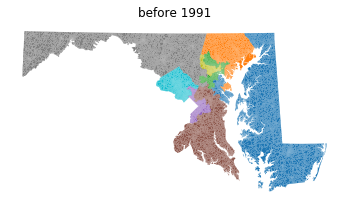

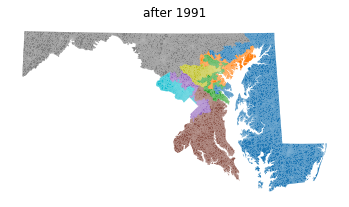

In [ ]:
#let's look at the districts
fig, ax = plt.subplots()
gdf.plot(column=gdf.old.astype(str), ax=ax,cmap='tab10')
plt.title("before 1991")
plt.axis('off')
plt.show()

fig, ax = plt.subplots()
gdf.plot(column=gdf.new.astype(str), ax=ax,cmap='tab10')
plt.title("after 1991")
plt.axis('off')
plt.show()

In [ ]:
#and now we can compute the entropy distance
print("entropy (new|old) = {:0.3f}".format(Ent_D_D(gdf, "new", "old", "TOTPOP")))

entropy (new|old) = 0.957


In [ ]:
#just for fun, let's check the symmetry condition
print("entropy (old|new) = {:0.3f}".format(Ent_D_D(gdf, "old", "new", "TOTPOP")))

entropy (old|new) = 0.952


Remember, $Ent(D_1, D_2) = Ent(D_2, D_1)$ if the districts are perfectly population balanced, but this is end of the 1980-1990 census cycle, so the old districts were a little unbalanced by this point, as we can see below:

In [ ]:
gdf.groupby(by="old").sum()["TOTPOP"]

old
256.0    682348
257.0    652916
258.0    643915
259.0    648921
260.0    714392
261.0    723165
262.0    539464
359.0    690401
Name: TOTPOP, dtype: int64

### Let's embed an ensemble of NC Congressional plans in the plane

In [ ]:
from gerrychain import Graph, Partition, updaters, MarkovChain, constraints
from functools import partial
from gerrychain.updaters import Tally
from gerrychain.proposals import recom
from gerrychain.accept import always_accept

In [ ]:
#let's load a North Carolina dual graph -- this may take a while!
gdf = gpd.read_file("./northcarolina/NC_VTD.shp")
graph = Graph.from_file("./northcarolina/NC_VTD.shp",ignore_errors=True)

In [ ]:
#here are some parameters you can play with
ensemble_size = 100 #how many plans to generate in your final ensemble
burn_in = 10 #throw away the first few steps of the chain
sample_interval = 10 #how often to sample from the chain -- the higher the better for a good ensemble

In [ ]:
#set up a ReCom chain using gerrychain
population_tracker = {
    "population": updaters.Tally("TOTPOP", alias="population"),
}
total_population = sum([graph.nodes[n]["TOTPOP"] for n in graph.nodes()])
initial_plan_to_start_chain = Partition(graph, "newplan", population_tracker)
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=total_population/13,
                   epsilon=0.02,
                   node_repeats=10
                  )
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_plan_to_start_chain, 0.02),
    ],
    accept=always_accept,
    initial_state=initial_plan_to_start_chain,
    total_steps=ensemble_size*sample_interval + burn_in
)

In [ ]:
#let's run the chain and store the output in the geodataframe -- could take a while depending on your parameters
counter=0
for i, step in enumerate(chain):
    if i >= burn_in and i % sample_interval == 0:
        print(counter, end=" ")
        gdf["plan_{}".format(counter)] = [
            step.assignment[x] for x in graph.nodes
        ]
        counter+=1

In [ ]:
#let's look at a few random plans from our ensemble
for i in range(3):
    plan_number = int(np.random.random()*ensemble_size)
    gdf.plot(column="plan_{}".format(plan_number), cmap='tab20')
    plt.axis('off')
    plt.title("plan # {}".format(plan_number))
    plt.show()

In [ ]:
#let's add three human-drawn plans to the ensemble and compute the pairwise entropy distances
plan_names = ["oldplan", "newplan", "judge"]+["plan_{}".format(x) for x in range(ensemble_size)]
M = np.zeros((len(plan_names),len(plan_names))) 
for i, p in enumerate(plan_names):
    print(i, end=" ")
    for j, q in enumerate(plan_names):
        if j > i:
            M[i,j] = Ent_D_D(gdf, p, q, "TOTPOP")/2+Ent_D_D(gdf, q, p, "TOTPOP")/2
M = M+M.T

In [ ]:
#M is our distance matrix -- we can view it as a heat map
plt.imshow(M, cmap='jet')
plt.title("pairwise distance matrix")

In [ ]:
#now we use MDS to embed the ensemble and human-drawn plans in the plane
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed')
pos=mds.fit(M).embedding_
X=[x[0] for x in pos]
Y=[x[1] for x in pos]
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(X,Y)
plt.scatter(X[:3], Y[:3], color='red')
plt.annotate("2012", (X[0],Y[0]))
plt.annotate("2016", (X[1],Y[1]))
plt.annotate("judge", (X[2],Y[2]))
plt.gca().set_aspect('equal')
plt.title("Plane embedding of North Carolina plans using entropy distance")